Import libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from sklearn.preprocessing import LabelEncoder

# visualization
import seaborn as sns
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


# some plot twiks
sns.set(style='white', context='notebook', palette='deep')
pylab.rcParams['figure.figsize'] = 12,8
sns.set_style('white')
%matplotlib inline

Getting data

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
combine = [train_df, test_df]

Let's see what we have here

In [3]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Assumptions

OK.
I'll try to fill up *Age* and *Embarked* fields with information from others.

Also *Cabin* may be helpful if I'll find Titanic plan - nose of the ship sinked first, so cabin location may influence on survivelence.

Another one suggestion is to take into account family survive rate when predict.

Now trivia:
* Kids survived
* Womens survived
* Rich people survived (better class)
* Embarking port affects

#### Make plots for assumptions

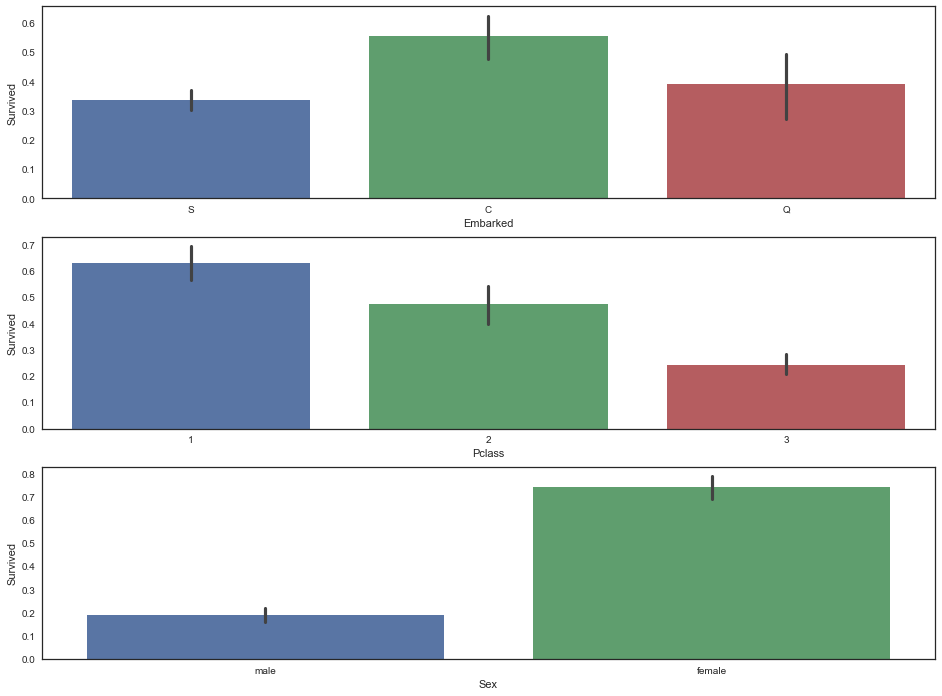

In [6]:
fig, saxis = plt.subplots(3, figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=train_df, ax = saxis[0])
sns.barplot(x = 'Pclass', y = 'Survived', data=train_df, ax = saxis[1])
sns.barplot(x = 'Sex', y = 'Survived', data=train_df, ax = saxis[2])

### 

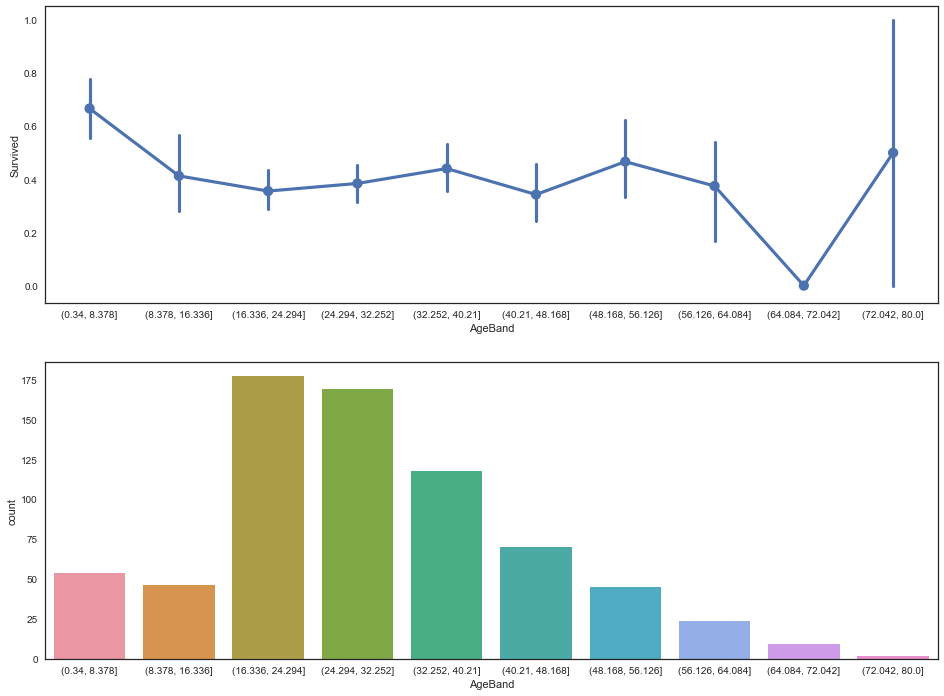

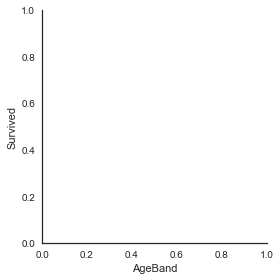

In [7]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 10)

fig, saxis = plt.subplots(2, figsize=(16,12))
sns.factorplot('AgeBand', 'Survived', data=train_df, ax=saxis[0])
sns.countplot('AgeBand', data=train_df, ax=saxis[1])

#### So, kids and elders survived better

### Scatter matrix for better visualisation

<Figure size 432x288 with 0 Axes>

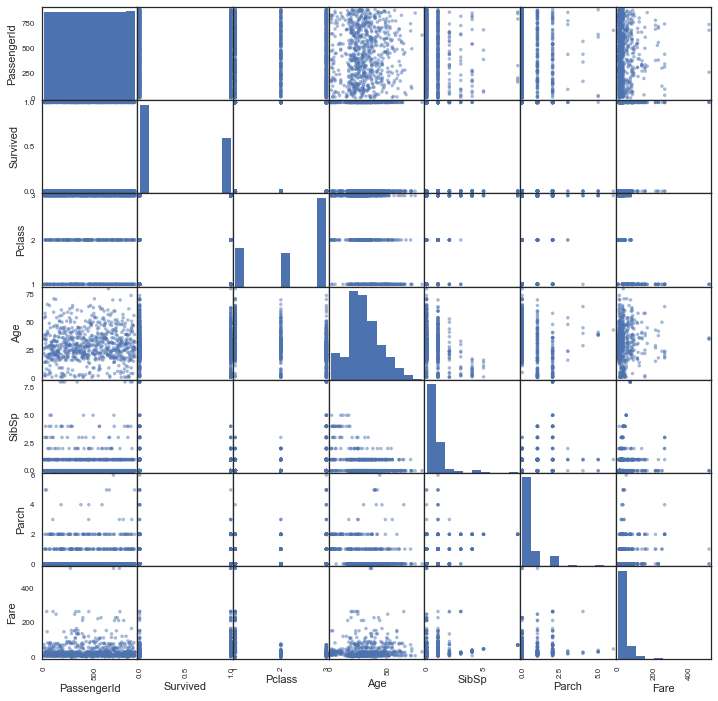

<Figure size 432x288 with 0 Axes>

In [8]:
pd.plotting.scatter_matrix(train_df, figsize=(12,12))
plt.figure()

## Filling missings

In [9]:
print(train_df.info())
print('-'*20)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
AgeBand        714 non-null category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 84.6+ KB
None
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-nul

Missings in *Age*, *Embarked* and *Cabin* fields. *AgeBand* will be rewrited.
*Fare* in test table will be filled also.

### Age

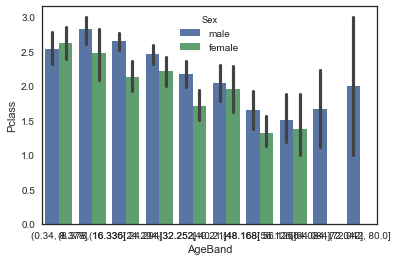

In [10]:
# wat?
sns.barplot('AgeBand', 'Pclass', hue='Sex', data=train_df)

In [11]:
# using all available data for finding median age
combo = pd.concat([train_df, test_df], sort=False)
age_table = combo.pivot_table(values='Age', index='Sex', columns='Pclass', aggfunc=np.median)
age_table

Pclass,1,2,3
Sex,,,
female,36.0,28.0,22.0
male,42.0,29.5,25.0


In [12]:
for dataset in combine:
    for sex in ('male', 'female'):
        for pclass in (1, 2, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == sex) & 
                        (dataset.Pclass == pclass), 'Age'] = age_table.loc[sex, pclass]

    # Round Age to int
    dataset['Age'] = dataset['Age'].round(0)
            
# replacing AgeBand in train and test
train_df['AgeBand'], bins = pd.cut(train_df['Age'], 10, retbins=True)
test_df['AgeBand'] = pd.cut(test_df['Age'], bins)

### Embarked

In [13]:
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,"(32.0, 40.0]"
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,"(56.0, 64.0]"


Let's look up for fare distribution for different ports for Pclass == 1.
We may guess where theese ladies embarked on ship by comparison of *Fare* distribution.

In [14]:
# no one else with that ticket
print(train_df[train_df['Ticket']=='113572'])
print('-'*20)
print(test_df[test_df['Ticket']=='113572'])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked       AgeBand  
61   female  38.0      0      0  113572  80.0   B28      NaN  (32.0, 40.0]  
829  female  62.0      0      0  113572  80.0   B28      NaN  (56.0, 64.0]  
--------------------
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, AgeBand]
Index: []


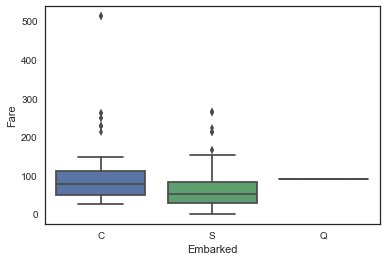

In [15]:
sns.boxplot(x='Embarked', y='Fare', data=train_df[train_df['Pclass'] == 1])
plt.show()

Well, I think it was 'C' port, but I'll check by lastname later also.

In [16]:
train_df['Embarked'].fillna(value='C', inplace=True)

### Fare

In [17]:
combo[combo['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,NaN


In [18]:
# just fill with median for this class and port
fare = np.nanmedian(combo.loc[(combo.Embarked == 'S') & (combo.Pclass == 3), 'Fare']) 
print(fare)
test_df['Fare'].fillna(fare, inplace=True)

8.05


## Cabin

*Cabin* is not filled well, and I don't know how to fill it better.
But maybe there is some useful information.

In [19]:
pd.unique(values=train_df['Cabin'].sort_values())

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

In [20]:
train_df['Deck'] = train_df['Cabin'].str[0]
# train_df['Deck'].fillna('Z', inplace=True)

In [21]:
# using all available data for finding median age
combo = pd.concat([train_df, test_df], sort=False)
age_table = combo.pivot_table(values='Age', index='Sex', columns='Pclass', aggfunc=np.median)
age_table

train_df.pivot_table(values='PassengerId', index='Deck', columns='Pclass', aggfunc=np.count_nonzero)

Pclass,1,2,3
Deck,,,
A,15.0,NaN,NaN
B,47.0,NaN,NaN
C,59.0,NaN,NaN
D,29.0,4.0,NaN
E,25.0,4.0,3.0
F,NaN,8.0,5.0
G,NaN,NaN,4.0
T,1.0,NaN,NaN


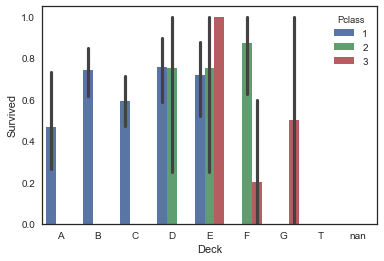

In [22]:
sns.barplot('Deck', 'Survived', hue='Pclass', data=train_df, order=pd.unique(values=train_df['Deck'].sort_values()))

In [23]:
train_df[train_df['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Deck
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,"(40.0, 48.0]",T


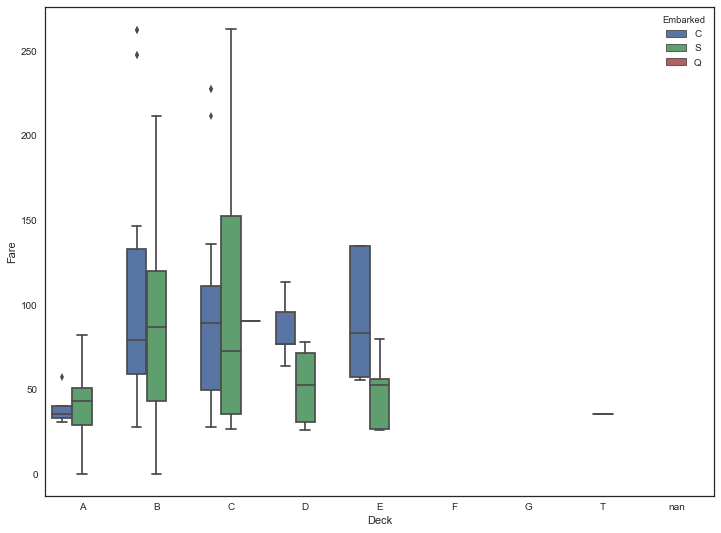

In [24]:
df = train_df[(train_df['Deck'] != 'Z') & (train_df['Pclass'] == 1) & (train_df['Fare'] < 500)]  # outlier
# sns.barplot('Deck', 'Fare', hue='Pclass', data=df, order=pd.unique(values=train_df['Deck'].sort_values()))
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(x='Deck', y='Fare', hue='Embarked', data=df, order=pd.unique(values=train_df['Deck'].sort_values()), ax=ax)

In [25]:
train_df[(train_df['Deck'] != 'Z') & (train_df['Pclass'] == 1) & (train_df['Embarked'] == 'Q')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Deck
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0,C78,Q,"(40.0, 48.0]",C
412,413,1,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0,C78,Q,"(32.0, 40.0]",C


In [26]:
train_df[train_df['Fare'] > 500]  # outlier

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Deck
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,"(32.0, 40.0]",NaN
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,"(32.0, 40.0]",B
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,"(32.0, 40.0]",B


Ok, now I see this:
* Tickets from S was cheeper, but not always
* Taking 2, 3 or 4 cabins should increase price, take it in account
* Deck may be filled, if another passenger with the same ticket has *Cabin* field filled
* Also, if ticket was bought for few persons, add 1 cabin for every person with NaN *Cabin*, at least for Pclass == 1

In [27]:
print(pd.unique(values=train_df['Cabin'].sort_values()))
print(pd.unique(values=test_df['Cabin'].sort_values()))

['A10' 'A14' 'A16' 'A19' 'A20' 'A23' 'A24' 'A26' 'A31' 'A32' 'A34' 'A36'
 'A5' 'A6' 'A7' 'B101' 'B102' 'B18' 'B19' 'B20' 'B22' 'B28' 'B3' 'B30'
 'B35' 'B37' 'B38' 'B39' 'B4' 'B41' 'B42' 'B49' 'B5' 'B50' 'B51 B53 B55'
 'B57 B59 B63 B66' 'B58 B60' 'B69' 'B71' 'B73' 'B77' 'B78' 'B79' 'B80'
 'B82 B84' 'B86' 'B94' 'B96 B98' 'C101' 'C103' 'C104' 'C106' 'C110' 'C111'
 'C118' 'C123' 'C124' 'C125' 'C126' 'C128' 'C148' 'C2' 'C22 C26'
 'C23 C25 C27' 'C30' 'C32' 'C45' 'C46' 'C47' 'C49' 'C50' 'C52' 'C54'
 'C62 C64' 'C65' 'C68' 'C7' 'C70' 'C78' 'C82' 'C83' 'C85' 'C86' 'C87'
 'C90' 'C91' 'C92' 'C93' 'C95' 'C99' 'D' 'D10 D12' 'D11' 'D15' 'D17' 'D19'
 'D20' 'D21' 'D26' 'D28' 'D30' 'D33' 'D35' 'D36' 'D37' 'D45' 'D46' 'D47'
 'D48' 'D49' 'D50' 'D56' 'D6' 'D7' 'D9' 'E10' 'E101' 'E12' 'E121' 'E17'
 'E24' 'E25' 'E31' 'E33' 'E34' 'E36' 'E38' 'E40' 'E44' 'E46' 'E49' 'E50'
 'E58' 'E63' 'E67' 'E68' 'E77' 'E8' 'F E69' 'F G63' 'F G73' 'F2' 'F33'
 'F38' 'F4' 'G6' 'T' nan]
['A11' 'A18' 'A21' 'A29' 'A34' 'A9' 'B10' '

In [28]:
# Let's clean weird cabin numbers
for dataset in combine:
    dataset.loc[(dataset['Cabin'] == 'T') | (dataset['Cabin'] == 'F'), 'Cabin'] = np.nan
    dataset['Cabin'] = dataset['Cabin'].str.replace('F ', '')

In [29]:
# Check "one ticket - one deck" assumption
combo = pd.concat([train_df, test_df], sort=False)
df = combo.loc[combo['Cabin'].notna(), ['Cabin', 'Ticket']]
df['Deck'] = df['Cabin'].str[0]
df.drop(columns='Cabin', inplace=True)
df.drop_duplicates(inplace=True)
pivot = df.pivot_table(index='Ticket', columns='Deck', aggfunc=np.count_nonzero)


In [30]:
pivot[pivot.sum(axis=1) > 2]

Deck,A,B,C,D,E,F,G
Ticket,,,,,,,
110465,2.0,NaN,2.0,NaN,NaN,NaN,NaN
PC 17485,2.0,NaN,NaN,NaN,2.0,NaN,NaN


Only 2 tickets with different decks. I'll ignore it ;)

In [31]:
combo[(combo['Ticket'] == '110465') | (combo['Ticket'] == 'PC 17485')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Deck
110,111,0.0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S,"(40.0, 48.0]",C
309,310,1.0,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C,"(24.0, 32.0]",E
475,476,0.0,1,"Clifford, Mr. George Quincy",male,42.0,0,0,110465,52.0000,A14,S,"(40.0, 48.0]",A
599,600,1.0,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,"(48.0, 56.0]",A


In [32]:
# 293
# Fill deck now
df.index = df['Ticket']
df.drop(columns='Ticket', inplace=True)
d = df.to_dict()['Deck']

In [33]:
for dataset in combine:
    dataset['Deck'] = dataset['Cabin'].str[0]
    dataset['Deck'].fillna(dataset['Ticket'].map(d), inplace=True)
    dataset['Deck'].fillna('N', inplace=True)
    
# 214 + 95 = 309 (only + 16)

## Features engeneering
### Title

In [34]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [35]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### Family size

In [36]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


### Is alone

In [37]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


### Fare bins

In [38]:
train_df['FareBand'], bins = pd.cut(train_df['Fare'], 10, retbins=True)
test_df['FareBand'] = pd.cut(test_df['Fare'], bins)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean()

,FareBand,Survived
0,"(-0.512, 51.233]",0.318306
1,"(51.233, 102.466]",0.660377
2,"(102.466, 153.699]",0.741935
3,"(153.699, 204.932]",1.000000
4,"(204.932, 256.165]",0.636364
5,"(256.165, 307.398]",0.666667
6,"(307.398, 358.63]",NaN
7,"(358.63, 409.863]",NaN
8,"(409.863, 461.096]",NaN
9,"(461.096, 512.329]",1.000000


### Drop columns

In [39]:
for dataset in combine:
    dataset.drop(columns=['Name', 'Ticket', 'Cabin', 'Age', 'Fare'], inplace=True)
train_df.drop(columns='PassengerId', inplace=True)

In [40]:
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeBand,Deck,Title,FamilySize,IsAlone,FareBand
0,0,3,male,1,0,S,"(16.0, 24.0]",N,Mr,2,0,"(-0.512, 51.233]"
1,1,1,female,1,0,C,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
2,1,3,female,0,0,S,"(24.0, 32.0]",N,Miss,1,1,"(-0.512, 51.233]"
3,1,1,female,1,0,S,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
4,0,3,male,0,0,S,"(32.0, 40.0]",N,Mr,1,1,"(-0.512, 51.233]"


#### Correlation will be leaved as is

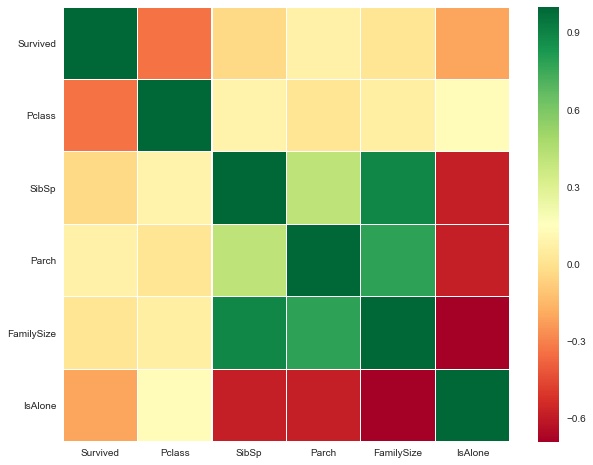

In [41]:
sns.heatmap(train_df.corr(),annot=False,cmap='RdYlGn',linewidths=0.2)  
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

## Modelling
### Logit reggresion

In [42]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

In [43]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Embarked,AgeBand,Deck,Title,FamilySize,IsAlone,FareBand
0,3,male,1,0,S,"(16.0, 24.0]",N,Mr,2,0,"(-0.512, 51.233]"
1,1,female,1,0,C,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
2,3,female,0,0,S,"(24.0, 32.0]",N,Miss,1,1,"(-0.512, 51.233]"
3,1,female,1,0,S,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
4,3,male,0,0,S,"(32.0, 40.0]",N,Mr,1,1,"(-0.512, 51.233]"


In [44]:
for c in ['Sex', 'Embarked', 'AgeBand', 'Deck', 'Title', 'FareBand']:
    encoder = LabelEncoder()
    encoder.fit(train_df[c])
    X_train[c + 'Enc'] = encoder.transform(X_train[c])
    X_test[c + 'Enc'] = encoder.transform(X_test[c])

In [45]:
X_train.drop(columns=['Sex', 'Embarked', 'AgeBand', 'Deck', 'Title', 'FareBand'], inplace=True)
X_test.drop(columns=['Sex', 'Embarked', 'AgeBand', 'Deck', 'Title', 'FareBand'], inplace=True)

In [46]:
X_train.head()

,Pclass,SibSp,Parch,FamilySize,IsAlone,SexEnc,EmbarkedEnc,AgeBandEnc,DeckEnc,TitleEnc,FareBandEnc
0,3,1,0,2,0,1,2,2,7,2,0
1,1,1,0,2,0,0,0,4,2,3,1
2,3,0,0,1,1,0,2,3,7,1,0
3,1,1,0,2,0,0,2,4,2,3,1
4,3,0,0,1,1,1,2,4,7,2,0


In [47]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

### XGBoost

In [48]:
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeBand,Deck,Title,FamilySize,IsAlone,FareBand
0,0,3,male,1,0,S,"(16.0, 24.0]",N,Mr,2,0,"(-0.512, 51.233]"
1,1,1,female,1,0,C,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
2,1,3,female,0,0,S,"(24.0, 32.0]",N,Miss,1,1,"(-0.512, 51.233]"
3,1,1,female,1,0,S,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
4,0,3,male,0,0,S,"(32.0, 40.0]",N,Mr,1,1,"(-0.512, 51.233]"


In [49]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

In [50]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Embarked,AgeBand,Deck,Title,FamilySize,IsAlone,FareBand
0,3,male,1,0,S,"(16.0, 24.0]",N,Mr,2,0,"(-0.512, 51.233]"
1,1,female,1,0,C,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
2,3,female,0,0,S,"(24.0, 32.0]",N,Miss,1,1,"(-0.512, 51.233]"
3,1,female,1,0,S,"(32.0, 40.0]",C,Mrs,2,0,"(51.233, 102.466]"
4,3,male,0,0,S,"(32.0, 40.0]",N,Mr,1,1,"(-0.512, 51.233]"


In [51]:
for c in ['Sex', 'Embarked', 'AgeBand', 'Deck', 'Title', 'FareBand']:
    encoder = LabelEncoder()
    encoder.fit(train_df[c])
    X_train[c + 'Enc'] = encoder.transform(X_train[c])
    X_test[c + 'Enc'] = encoder.transform(X_test[c])
    
    X_train.drop(columns=c, inplace=True)
    X_test.drop(columns=c, inplace=True)

In [52]:
boost = GradientBoostingClassifier()
boost.fit(X_train, Y_train)
Y_pred = boost.predict(X_test)
acc_boost = round(boost.score(X_train, Y_train) * 100, 2)
acc_boost

87.21

In [53]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('./output/submission.csv', index=False)

### Private leaderboard shows 'Your submission scored 0.77033'
Overfit, as you understand :)
Next step: use GridSearch + Stratified K-Fold + Shrinkage for classificator